In [1]:
from __future__ import print_function

In [2]:
import urllib
import bz2
import os
import numpy as np
import torch
from torch import autograd

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cpu')

In [4]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

In [5]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

In [6]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(int, file.readline().split())
    
        camera_indices = np.empty(n_observations, dtype = int)
        point_indices = np.empty(n_observations, dtype = int)
        points_2d = torch.empty(n_observations, 2, device = device)

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = camera_index
            point_indices[i] = point_index
            points_2d[i] = torch.tensor([float(x), float(y)])

            camera_params = torch.empty(n_cameras*9, device = device, requires_grad = True)

        for i in range(n_cameras*9):
            camera_params[i] = float(file.readline())

        camera_params = camera_params.view(n_cameras, -1)

        points_3d = torch.empty(n_points*3, device = device, requires_grad = True)

        for i in range(n_points*3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.view(n_points, -1)
            
    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [72]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [73]:
n_cameras = camera_params.size()[0]
n_points = points_3d.size()[0]

n = 9*n_cameras
m = 2*points_2d.size()[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 441
Total number of residuals: 63686


In [74]:
camera_indices = torch.tensor(camera_indices, device = device)
point_indices = torch.tensor(point_indices, device = device)

In [68]:
def rotate(points, rot_vecs):
    
    theta = torch.norm(rot_vecs, dim = 1, keepdim=True)
    v = rot_vecs/theta
#         v[v != v] = 0.
#     print(v.size(), points.size())
    
    dot = torch.sum(points*v, dim = 1, keepdim = True)
    
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    ans = cos_theta*points + sin_theta*torch.cross(v, points) + dot*(1-cos_theta)*v
    
    return ans

In [75]:
def project(points, camera_params):
    points_proj = rotate(points, camera_params[:, :3])
    points_proj = points_proj + camera_params[:, 3:6]
    denom = points_proj.clone()[:, 2].view(-1,1)
    points_proj_2 = -points_proj[:, :2]/denom
    f = camera_params[:, 6].clone()
    k1 = camera_params[:, 7].clone()
    k2 = camera_params[:, 8].clone()
    
    n = torch.sum(points_proj_2**2, dim = 1)
    r = 1 + n*k1 + k2*n**2
    points_proj_3 = points_proj_2*(r*f).view(-1,1)
    return points_proj_3

In [70]:
def fun(camera_params, points_3d, n_cameras, n_points, camera_indices, point_indices, points_2d):
#     cp = params[:n_cameras*9].view(n_cameras, 9)
#     p3d = params[n_cameras*9:].view(n_points, 3)
#     points_proj = project(p3d[point_indices], cp[camera_indices])
    points_3d_2 = torch.index_select(points_3d.clone(), 0, point_indices)
    camera_params_2 = torch.index_select(camera_params.clone(), 0, camera_indices)
    points_proj = project(points_3d_2, camera_params_2)
    ans = points_proj - points_2d
    return ans.view(ans.numel())

In [38]:
x0 = torch.cat((camera_params.view(camera_params.numel()), points_3d.view(points_3d.numel())), 0)


In [39]:
f0 = fun(camera_params, points_3d, n_cameras, n_points, camera_indices, point_indices, points_2d)

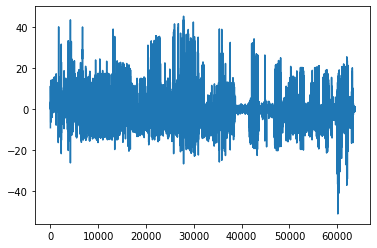

In [50]:
plt.plot(f0.detach().numpy())

In [76]:
for i in range(10):
    f = fun(camera_params, points_3d, n_cameras, n_points, camera_indices, point_indices, points_2d)
    
    loss = f.pow(2).sum()
    
    print(i, " --> ", loss.item())
    loss.backward()

    
    with autograd.detect_anomaly():
        camera_params -= lr*camera_params.grad
        points_3d -= lr*points_3d.grad
        
        camera_params.grad.zero_()
        points_3d.grad.zero_()

0  -->  1701824.875


RuntimeError: leaf variable has been moved into the graph interior

In [16]:
torch.autograd.set_detect_anomaly(True)

In [61]:
torch.index_select(points_3d, 0, torch.tensor(point_indices))

tensor([[-0.6120,  0.5718, -1.8471],
        [-0.6120,  0.5718, -1.8471],
        [-0.6120,  0.5718, -1.8471],
        ...,
        [-0.8193,  0.0765, -4.5143],
        [-0.7480,  0.0371, -4.8132],
        [-0.7480,  0.0371, -4.8132]], grad_fn=<IndexSelectBackward>)